In [11]:
from pathlib import Path
from health_lifestyle_diabetes.infrastructure.data_sources.csv_dataset_repository import CSVDatasetRepository
from health_lifestyle_diabetes.infrastructure.logger.loguru_logger import LoguruLogger
from health_lifestyle_diabetes.application.use_cases.load_dataset_use_case import LoadDatasetUseCase
from health_lifestyle_diabetes.infrastructure.utils.config_loader import YamlConfigLoader
from health_lifestyle_diabetes.infrastructure.utils.paths import get_repository_root
from health_lifestyle_diabetes.infrastructure.logger.config import configure_logging
from health_lifestyle_diabetes.infrastructure.training_diagnostics.diagnostics import (
    BoostingTrainingDiagnostics,
)
from health_lifestyle_diabetes.infrastructure.tracking.run_name_generator import generate_run_name
from health_lifestyle_diabetes.infrastructure.splitters.sklearn_splitter import SklearnDatasetSplitter
from health_lifestyle_diabetes.application.use_cases.split_dataset_use_case import SplitDatasetUseCase
from health_lifestyle_diabetes.infrastructure.features_selections import features_selection as fs
from health_lifestyle_diabetes.infrastructure.model_trainers.lightgbm_trainer import (
    LightGBMTrainer,
)
from health_lifestyle_diabetes.infrastructure.model_trainers.catboost_trainer import (
    CatBoostTrainer,
)

from health_lifestyle_diabetes.infrastructure.model_trainers.xgboost_trainer import (
    XGBoostTrainer,
)



# Configure logging
configure_logging(env="dev")

# Get repository root path
root = get_repository_root()

# Load configuration
config_loader = YamlConfigLoader()
paths = config_loader.load_config(f"{root}/configs/paths.yaml")
train_paths = get_repository_root() / Path(paths["data"]["input"]["train_dataset"])

# Injection de dépendance comme en entreprise
repository = CSVDatasetRepository(source_path=train_paths, logger=LoguruLogger())
load_uc = LoadDatasetUseCase(repository=repository, logger=LoguruLogger())

# Exécution
dataset = load_uc.execute()

display(dataset.head()) # Affiche les 5 premières lignes pour validation.
print(f"le dataset chargé a {dataset.shape[0]} lignes et {dataset.shape[1]} colonnes")

2025-12-28 23:40:06 | INFO     | config.py:67 | configure_logging() | Loguru configuré avec succès (mode: dev) | {'env': 'dev'}
2025-12-28 23:40:06 | INFO     | load_dataset_use_case.py:18 | execute() | Démarrage du chargement du dataset... | {}
2025-12-28 23:40:06 | INFO     | csv_dataset_repository.py:54 | load_dataset() | Chargement du dataset depuis : /Users/surelmanda/Downloads/ml-projects/Clean-Architecture-MLops/health_lifestyle_diabetes/data/input/train.csv | {}
2025-12-28 23:40:06 | INFO     | csv_dataset_repository.py:61 | load_dataset() | Dataset chargé avec succès (818 lignes, 52 colonnes). | {}
2025-12-28 23:40:06 | INFO     | load_dataset_use_case.py:20 | execute() | Dataset chargé : 818 lignes, 52 colonnes. | {}


,Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,glucose_diff,glycemic_load,dyslipidemia_flag,cardiometabolic_burden_score,bp_ratio,activity_adequacy_ratio,screen_sleep_ratio,sedentary_risk_flag,lifestyle_score,sleep_efficiency
0,80,Female,Black,Highschool,Low,Employed,Ex-Smoker,2,94,5.8,...,75,2632.9,1,3,1.600000,0.626667,1.430556,1,4,0.637168
1,38,Female,White,Highschool,Upper-Middle,Employed,Current,1,131,6.3,...,42,1992.8,0,0,1.279070,0.873333,0.971429,1,6,0.897436
2,49,Female,Asian,Postgraduate,Lower-Middle,Employed,Ex-Smoker,5,320,6.3,...,43,2599.0,0,1,1.430380,2.133333,0.958333,0,6,0.911392
3,54,Female,Asian,Highschool,Upper-Middle,Employed,Current,2,98,2.8,...,38,3248.7,0,1,1.718750,0.653333,1.115942,1,2,0.793103
4,50,Male,Asian,Graduate,Upper-Middle,Employed,Never,3,35,8.2,...,50,2494.0,0,1,1.373494,0.233333,1.605634,1,6,0.572581


le dataset chargé a 818 lignes et 52 colonnes


In [12]:
# 1) Load config
cfg = YamlConfigLoader().load_config(f"{get_repository_root()}/configs/splitter.yaml")["splitter"]

# 2) Logger + DI (Dépendency Injection)
logger = LoguruLogger()
splitter = SklearnDatasetSplitter(
    train_size=cfg["train_size"],
    target_column=cfg["target_column"],
    random_state=cfg["random_state"],
    logger=logger,
)

# 3) Use Case orchestré
use_case = SplitDatasetUseCase(splitter=splitter, logger=logger)
train_df, test_df = use_case.execute(df=dataset)

# 4) Vérification
#print(train_df.shape, valid_df.shape)
#train_df.head()

2025-12-28 23:40:06 | DEBUG    | sklearn_splitter.py:37 | __init__() | SklearnDatasetSplitter initialized | {}
2025-12-28 23:40:06 | INFO     | split_dataset_use_case.py:41 | execute() | Démarrage du split dataset... | {}
2025-12-28 23:40:06 | INFO     | sklearn_splitter.py:42 | split() | Starting dataset split | {}
2025-12-28 23:40:06 | INFO     | sklearn_splitter.py:57 | split() | Split done | train=(695, 52) | test=(123, 52) | {}
2025-12-28 23:40:06 | INFO     | split_dataset_use_case.py:45 | execute() | Split terminé : train=(695, 52), test=(123, 52) | {}
2025-12-28 23:40:06 | INFO     | split_dataset_use_case.py:48 | execute() | Sauvegarde des datasets splittés... | {}
2025-12-28 23:40:06 | INFO     | split_dataset_use_case.py:52 | execute() | Datasets sauvegardés avec succès. | {}


In [13]:
## 1. Importations des couches Application et Infrastructure
from health_lifestyle_diabetes.infrastructure.feature_engineering.pipeline_feature_engineering import FeatureEngineeringPipeline
from health_lifestyle_diabetes.application.use_cases.build_features_use_case import BuildFeaturesUseCase
from health_lifestyle_diabetes.infrastructure.logger.loguru_logger import LoguruLogger

## 2. Initialisation du pipeline de preprocessing et du cas d'utilisation
pipeline = FeatureEngineeringPipeline(logger=LoguruLogger())
build_features_uc = BuildFeaturesUseCase(pipeline=pipeline)
# Exécution de la transformation des données brutes en vecteurs de caractéristiques
train_enriche_df = build_features_uc.execute(data=train_df)

2025-12-28 23:40:06 | INFO     | pipeline_feature_engineering.py:82 | transform() | Démarrage du pipeline complet de Feature Engineering... | {}
2025-12-28 23:40:06 | INFO     | exclusion.py:36 | drop_leakage_columns() | Vérification des colonnes à risque de data leakage... | {}
2025-12-28 23:40:06 | INFO     | exclusion.py:44 | drop_leakage_columns() | Aucune colonne de leakage détectée. | {}
2025-12-28 23:40:06 | INFO     | base_preprocessing.py:25 | clean_categorical_variables() | Nettoyage des variables catégorielles... | {}
2025-12-28 23:40:06 | INFO     | base_preprocessing.py:32 | clean_categorical_variables() | Libellés uniformisés avec succès. | {}
2025-12-28 23:40:06 | INFO     | demographics_features.py:82 | transform() | Création des variables démographiques... | {}
2025-12-28 23:40:06 | INFO     | demographics_features.py:68 | _create_age_group() | Utilisation du découpage d'âge en 3 catégories. | {}
2025-12-28 23:40:06 | INFO     | demographics_features.py:111 | transform

In [14]:
use_case = SplitDatasetUseCase(splitter=splitter, logger=logger,save=False)
train_df_enriched, valid_df_enriched  = use_case.execute(df=train_enriche_df)
print("Dataset successfully split into training and validation sets.")
print(f"Train set shape: {train_df_enriched.shape}")
print(f"Validation set shape: {valid_df_enriched.shape}")

2025-12-28 23:40:06 | INFO     | split_dataset_use_case.py:41 | execute() | Démarrage du split dataset... | {}
2025-12-28 23:40:06 | INFO     | sklearn_splitter.py:42 | split() | Starting dataset split | {}
Dataset successfully split into training and validation sets.
Train set shape: (590, 52)
Validation set shape: (105, 52)
2025-12-28 23:40:06 | INFO     | sklearn_splitter.py:57 | split() | Split done | train=(590, 52) | test=(105, 52) | {}
2025-12-28 23:40:06 | INFO     | split_dataset_use_case.py:45 | execute() | Split terminé : train=(590, 52), test=(105, 52) | {}


In [15]:
X_train = train_df_enriched[fs.SELECTED_FEATURES]
y_train = train_df_enriched[fs.TARGET_COLUMN]

# Pour la validation
X_valid = valid_df_enriched[fs.SELECTED_FEATURES]
y_valid = valid_df_enriched[fs.TARGET_COLUMN]
# Affichage des dimensions des matrices et vecteurs
print("Étape 5.3 : Dimensions finales des matrices de caractéristiques (X) :")
print(f"- X_train (Features d'entraînement) : {X_train.shape[0]} lignes, {X_train.shape[1]} colonnes")
print(f"- X_valid (Features de validation)  : {X_valid.shape[0]} lignes, {X_valid.shape[1]} colonnes")

print("\nÉtape 5.4 : Vérification des vecteurs cibles (y) :")
print(f"- y_train : {y_train.shape[0]} lignes")
print(f"- y_valid : {y_valid.shape[0]} lignes")

Étape 5.3 : Dimensions finales des matrices de caractéristiques (X) :
- X_train (Features d'entraînement) : 590 lignes, 5 colonnes
- X_valid (Features de validation)  : 105 lignes, 5 colonnes

Étape 5.4 : Vérification des vecteurs cibles (y) :
- y_train : 590 lignes
- y_valid : 105 lignes


2025-12-28 23:40:06 | INFO     | catboost_trainer.py:38 | __init__() | CatBoostTrainer initialisé avec les paramètres fournis. | {}
2025-12-28 23:40:06 | INFO     | catboost_trainer.py:111 | train() | Entraînement CatBoost | train_shape=(590, 5) | valid_shape=(105, 5) | {}
2025-12-28 23:40:06 | INFO     | catboost_trainer.py:127 | train() | Détection automatique des variables catégorielles : ['glucose_status'] | {}
2025-12-28 23:40:06 | INFO     | catboost_trainer.py:137 | train() | Démarrage de l'entraînement CatBoost. | {}
0:	learn: 0.5826759	test: 0.5716457	best: 0.5716457 (0)	total: 3.91ms	remaining: 5.87s
100:	learn: 0.1084134	test: 0.1615112	best: 0.1555392 (36)	total: 101ms	remaining: 1.4s
200:	learn: 0.0498292	test: 0.1664476	best: 0.1555392 (36)	total: 195ms	remaining: 1.26s
300:	learn: 0.0309042	test: 0.1812240	best: 0.1555392 (36)	total: 294ms	remaining: 1.17s
400:	learn: 0.0196520	test: 0.1933794	best: 0.1555392 (36)	total: 394ms	remaining: 1.08s
500:	learn: 0.0152958	test:

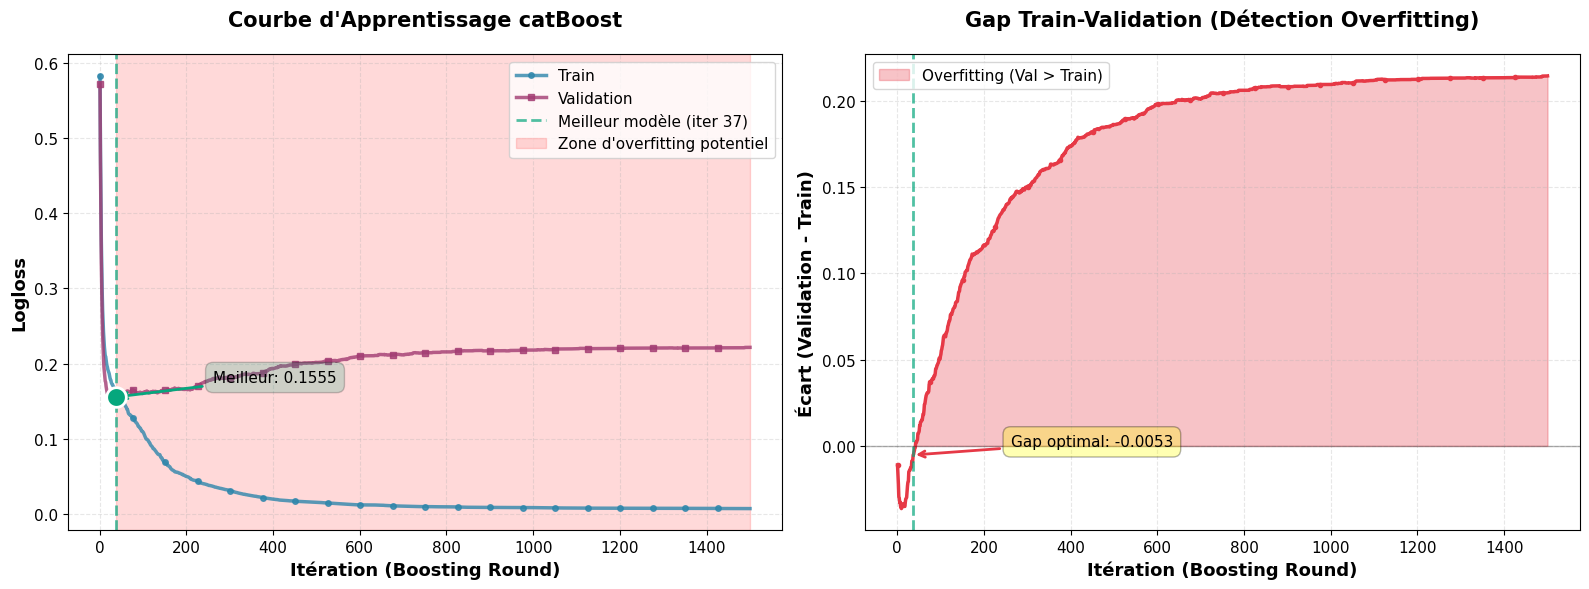

In [16]:
# ============================================================
# Paramètres CatBoost
# ============================================================
catboost_params = {
    "iterations": 1500,
    "learning_rate": 0.1,
    "depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "Logloss",  #"AUC"
    "verbose": 100,   # ← test du verbose
}

# ============================================================
# Entraînement
# ============================================================
trainer = CatBoostTrainer(params=catboost_params,logger = LoguruLogger())

model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle entraîné :", model)


# ============================================================
# Plot des diagnostics d'entraînement
# ============================================================
EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="CATB")
MODEL_NAME = "catBoost"

diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name=MODEL_NAME,
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",  # "matplotlib" ou "plotly"
    save_figure=True,
)


2025-12-28 23:40:08 | INFO     | xgboost_trainer.py:31 | __init__() | XGBoostTrainer initialisé avec les paramètres fournis. | {}
2025-12-28 23:40:08 | INFO     | xgboost_trainer.py:91 | train() | XGBoost - Entraînement | train=(590, 5), valid=(105, 5) | {}
2025-12-28 23:40:08 | DEBUG    | xgboost_trainer.py:95 | train() | XGBoost - Hyperparamètres: {'n_estimators': 1500, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'eval_metric': 'logloss'} | {}
2025-12-28 23:40:08 | INFO     | xgboost_trainer.py:101 | train() | XGBoost - Variables catégorielles détectées : ['glucose_status'] | {}
2025-12-28 23:40:08 | INFO     | xgboost_trainer.py:114 | train() | XGBoost - Démarrage de l'entraînement... | {}
[0]	validation_0-logloss:0.66625	validation_1-logloss:0.66528
[1]	validation_0-logloss:0.65901	validation_1-logloss:0.65783
[2]	validation_0-logloss:0.65208	validation_1-logloss:0.65058
[3]	validation_0-logloss:0.64518	validation_1-logloss:

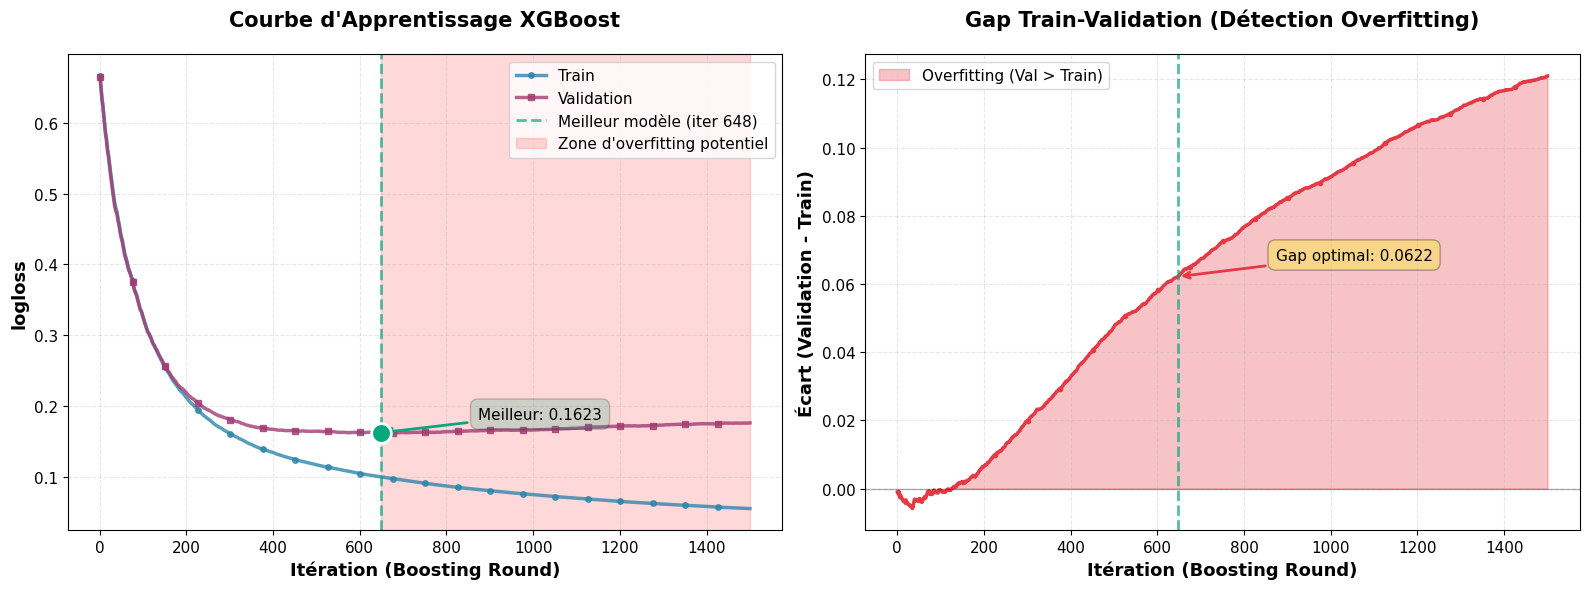

In [17]:
# ============================================================
# Paramètres XGBoost
# ============================================================
xgb_params = {
    "n_estimators": 1500,
    "max_depth": 6,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "eval_metric":"logloss",   # métrique standard binaire
    #"verbose": False,
    #"early_stopping_rounds": 50,  # géré dans le trainer si valid set
}


# ============================================================
# Entraînement
# ============================================================
trainer = XGBoostTrainer(
    params=xgb_params,
    logger=LoguruLogger()
)

model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle XGBoost entraîné :", model)

# ============================================================
# Plot des diagnostics d'entraînement
# ============================================================
EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="XGB")
MODEL_NAME = "XGBoost"

diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name=MODEL_NAME,
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",  # "matplotlib" ou "plotly"
    save_figure=True,
)


2025-12-28 23:47:13 | INFO     | lightgbm_trainer.py:20 | __init__() | Initialisation LightGBMTrainer terminée. | {}
2025-12-28 23:47:13 | DEBUG    | lightgbm_trainer.py:30 | train() | Début de la méthode train() | {}
2025-12-28 23:47:13 | INFO     | lightgbm_trainer.py:33 | train() | Validation des données... | {}
2025-12-28 23:47:13 | INFO     | lightgbm_trainer.py:42 | train() | Taille train: (590, 5) | {}
2025-12-28 23:47:13 | INFO     | lightgbm_trainer.py:43 | train() | Taille valid: (105, 5) | {}
2025-12-28 23:47:13 | INFO     | lightgbm_trainer.py:51 | train() | Détection et conversion des colonnes catégorielles... | {}
2025-12-28 23:47:13 | DEBUG    | lightgbm_trainer.py:55 | train() | Colonnes catégorielles détectées: ['hba1c', 'glucose_fasting'] | {}
2025-12-28 23:47:13 | INFO     | lightgbm_trainer.py:58 | train() | Initialisation du modèle LightGBM... | {}
2025-12-28 23:47:13 | DEBUG    | lightgbm_trainer.py:59 | train() | Hyperparamètres LightGBM: {'n_estimators': 1500, '

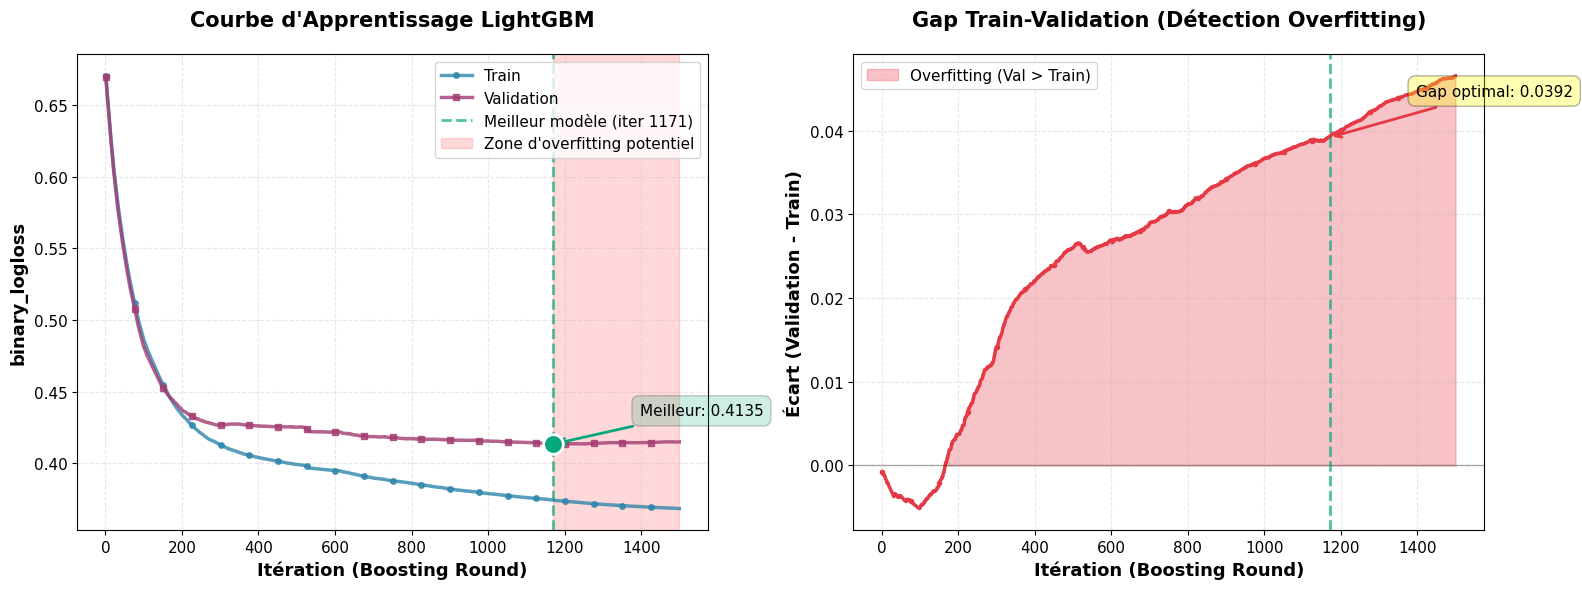

In [18]:
# ============================================================
# Paramètres LightGBM
# ============================================================
lgbm_params = {
    "n_estimators": 1500,
    "learning_rate": 0.01,
    "max_depth": 4,
    "num_leaves": 31,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "metric": "logloss",          # métrique suivie pendant l'entraînement
    #"early_stopping_rounds": 50,  # géré si un jeu de validation est fourni
    "verbosity": -1,  # masque tous les logs
}


# ============================================================
# Entraînement
# ============================================================
trainer = LightGBMTrainer(
    params=lgbm_params,
    logger=LoguruLogger()
)

model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle LightGBM entraîné :", model)

# ============================================================
# Plot des diagnostics d'entraînement
# ============================================================
EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="LGBM")
MODEL_NAME = "LightGBM"

diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name=MODEL_NAME,
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",      # "matplotlib" ou "plotly"
    save_figure=True,
)